# Sentiment analysis on IMDB large movie review dataset

Get the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/)

In [1]:
from glob import glob
import pandas as pd
import io
import numpy as np
from IPython.display import SVG

from keras import models, layers
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


## Prepare dataset

In [2]:
def parse_text(text):
    return text.lower().strip()

def read_and_append_files(folder, label):
    texts = []
    for file in glob('./aclImdb/{0}/*.txt'.format(folder)):
        with open(file, 'r') as f:
            text = f.read()
            text = parse_text(text)
            texts.append((text, label))
            
    return texts

def make_df(pos, neg):
    df = pd.concat([pd.DataFrame(pos),
                    pd.DataFrame(neg)])\
           .sample(frac=1)\
           .reset_index(drop=True)
    df.columns = ['review', 'label']
    
    return df

In [3]:
train_pos = read_and_append_files('train/pos', 1)
train_neg = read_and_append_files('train/neg', 0)

test_pos = read_and_append_files('test/pos', 1)
test_neg = read_and_append_files('test/neg', 0)

In [4]:
train_df = make_df(train_pos, train_neg)
test_df = make_df(test_pos, test_neg)

In [5]:
train_df.head()

,review,label
0,dynasty revisited in hawaii... full of clichés...,0
1,"it's a road movie, with a killer on-board. bri...",1
2,my father was the warden of the prison (he is ...,1
3,"yes, it's flawed - especially if you're into h...",1
4,"if i'm going to watch a porn movie, i prefer i...",1


In [6]:
test_df.head()

,review,label
0,"sadly, every single person i ask about this se...",1
1,this film is about a woman falling in love wit...,0
2,it is important and only fair to remember that...,1
3,"savage guns (video title) is a dirt cheap, bot...",0
4,"my god, ryan gosling has made a lot of deep ch...",1


## Embeddings

I use [Fast Text pre trained embeddings](https://fasttext.cc/docs/en/english-vectors.html).

In [7]:
t = Tokenizer()
t.fit_on_texts(train_df['review'])

In [8]:
def load_vectors(fname, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in word_index:
            w = word_index[tokens[0]]
            embedding_matrix[w] = np.fromiter(map(float, tokens[1:]), 'float')
    
    return embedding_matrix

In [10]:
%time vectors = load_vectors('/Users/eric/Code/wiki.en.vec', t.word_index)

CPU times: user 1min 50s, sys: 8.85 s, total: 1min 59s
Wall time: 2min 18s


In [11]:
vectors.shape

(88566, 300)

## Machine Learning with Keras

In [10]:
x_train = t.texts_to_matrix(train_df['review'])
y_train = train_df['label']

x_test = t.texts_to_matrix(test_df['review'])
y_test = test_df['label']

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 88566), (25000,), (25000, 88566), (25000,))

### Logistic regression

In [12]:
i = layers.Input(shape=(x_train.shape[1],))
h = layers.Dense(units=1, activation='sigmoid')(i)
model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['binary_accuracy'])

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=5)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 36s 1ms/step - loss: 0.5731 - binary_accuracy: 0.7910 - val_loss: 0.5044 - val_binary_accuracy: 0.8171
Epoch 2/5
25000/25000 [==============================] - 76s 3ms/step - loss: 0.4611 - binary_accuracy: 0.8375 - val_loss: 0.4449 - val_binary_accuracy: 0.8340
Epoch 3/5
25000/25000 [==============================] - 52s 2ms/step - loss: 0.4135 - binary_accuracy: 0.8515 - val_loss: 0.4101 - val_binary_accuracy: 0.8464
Epoch 4/5
25000/25000 [==============================] - 42s 2ms/step - loss: 0.3850 - binary_accuracy: 0.8603 - val_loss: 0.3906 - val_binary_accuracy: 0.8511
Epoch 5/5
25000/25000 [==============================] - 65s 3ms/step - loss: 0.3653 - binary_accuracy: 0.8666 - val_loss: 0.3753 - val_binary_accuracy: 0.8560


### Averaging Embeddings

In [12]:
x_train = pad_sequences(t.texts_to_sequences(train_df['review']), maxlen=500)
y_train = train_df['label']

x_test = pad_sequences(t.texts_to_sequences(test_df['review']), maxlen=500)
y_test = test_df['label']

In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 500), (25000,), (25000, 500), (25000,))

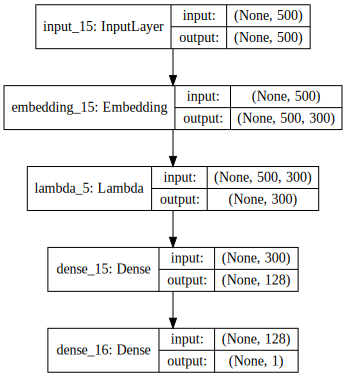

In [32]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

h = embedding_layer(i)
h = layers.Lambda(lambda r: K.mean(r, axis=1))(h)
h = layers.Dense(128, activation='relu')(h)
h = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [21]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 20s 809us/step - loss: 0.5878 - binary_accuracy: 0.7067 - val_loss: 0.5193 - val_binary_accuracy: 0.7716
Epoch 2/2
25000/25000 [==============================] - 19s 748us/step - loss: 0.4729 - binary_accuracy: 0.7994 - val_loss: 0.4543 - val_binary_accuracy: 0.8092


### Embeddings and GRU

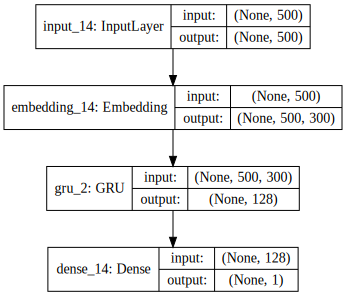

In [31]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

h = embedding_layer(i)
h = layers.GRU(128)(h)
h = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [23]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 946s 38ms/step - loss: 0.4530 - binary_accuracy: 0.7735 - val_loss: 0.3029 - val_binary_accuracy: 0.8716
Epoch 2/2
25000/25000 [==============================] - 840s 34ms/step - loss: 0.2804 - binary_accuracy: 0.8851 - val_loss: 0.2725 - val_binary_accuracy: 0.8860


### Embeddings and CNN

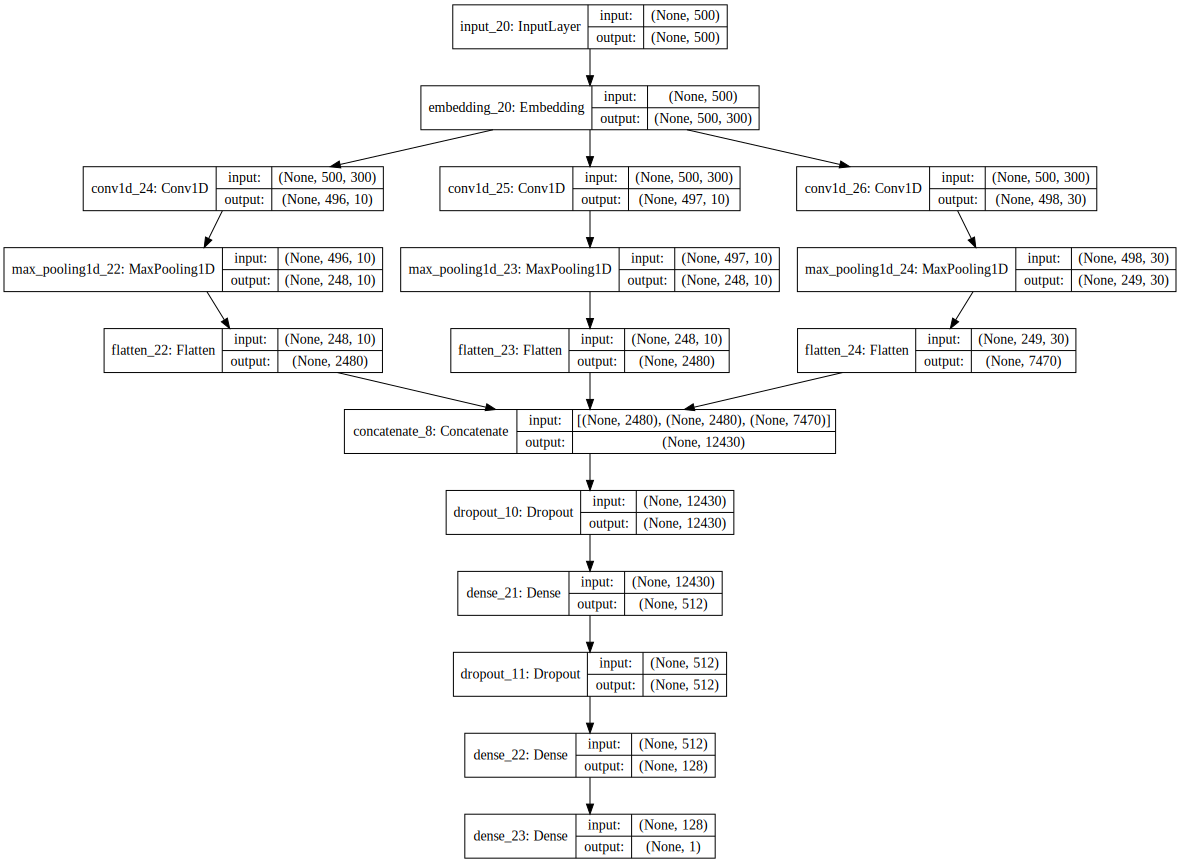

In [40]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

text_embedding = embedding_layer(i)

convs = []

for layer_params in [(10, 5), (10, 4), (30, 3)]:
    conv = layers.Conv1D(filters=layer_params[0],
                         kernel_size=layer_params[1],
                         activation='relu')(text_embedding)
    conv = layers.MaxPooling1D(pool_size=2)(conv)
    conv = layers.Flatten()(conv)
    convs.append(conv)

concat = layers.concatenate(convs)
dropout = layers.Dropout(0.3)(concat)
hidden = layers.Dense(512, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(hidden)
hidden = layers.Dense(128, activation='relu')(dropout)
output = layers.Dense(1, activation='softmax')(hidden)

model = models.Model(inputs=[i], outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# not working well yet

model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)